In [2]:
import argparse
import jinja2
import logging
import MDAnalysis as mda
import numpy as np
from pdb2pqr import run_pdb2pqr
import propka.run as pkrun
import itertools
import os
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=12, family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}\usepackage{amsmath}'
plt.rcParams['figure.dpi'] = 300

In [15]:
#git_dir='/Users/anze/Git/pdb2xyz/'
git_dir='/home/anze/Work/Git/pdb2xyz/'
#git_dir='/home/anze/Work/Git/DLVO-fitting/'

#os.chdir(git_dir + 'lysozyme_test/')
os.chdir(git_dir + 'cgn_test/')
#os.chdir(git_dir + 'duello_PMFs/BSA/')

### If necessary, split a PDB into separate chains

In [8]:
'''
%%capture --no-stdout

# split a PDB file into separate chains

PDB_id='4F5S'
pdb_file='%s.pdb' % PDB_id

from Bio.PDB import PDBParser
from Bio.PDB.PDBIO import PDBIO

parser = PDBParser()
io = PDBIO()

structure = parser.get_structure(PDB_id, pdb_file)
pdb_chains = structure.get_chains()
for chain in pdb_chains:
    io.set_structure(chain)
    io.save(structure.get_id() + "_" + chain.get_id() + ".pdb")
'''

'\n%%capture --no-stdout\n\n# split a PDB file into separate chains\n\nPDB_id=\'4F5S\'\npdb_file=\'%s.pdb\' % PDB_id\n\nfrom Bio.PDB import PDBParser\nfrom Bio.PDB.PDBIO import PDBIO\n\nparser = PDBParser()\nio = PDBIO()\n\nstructure = parser.get_structure(PDB_id, pdb_file)\npdb_chains = structure.get_chains()\nfor chain in pdb_chains:\n    io.set_structure(chain)\n    io.save(structure.get_id() + "_" + chain.get_id() + ".pdb")\n'

### Get protonation states via propka

In [16]:
#PDB_id='4LZT'
PDB_id='7KTZ'
#PDB_id='4F5S_A'
pdb_file='%s.pdb' % PDB_id

In [17]:
pkrun.single(pdb_file)

In [18]:
# obtain a list of partial charges based on propka-determined pKa values
def partial_charges(propka_file,pH):

    with open(propka_file) as fp:
        result = list(itertools.takewhile(lambda x: '---' not in x, 
            itertools.dropwhile(lambda x: 'Group' not in x, fp)))

    result=result[1:]
    result=np.array([line.split()[:4] for line in result])

    negative=['C-','ASP','GLU','TYR','CYS']
    positive=['N+','ARG','LYS','HIS']

    pqr={}

    for i,entry in enumerate(result):

        AA=str(entry[0])
        resid=str(entry[1])
        segid=str(entry[2])
        pKa=float(entry[-1])

        if AA in negative: pqr[(AA,resid,segid)] = - 10**(pH-pKa) / (1 + 10**(pH-pKa)) #pqr[i,-1] = '%.6f' % (- 10**(pH-pKa) / (1 + 10**(pH-pKa)))
        elif AA in positive: pqr[(AA,resid,segid)] = 1.0 - 10**(pH-pKa) / (1 + 10**(pH-pKa)) #pqr[i,-1] = '%.6f' % (1.0 - 10**(pH-pKa) / (1 + 10**(pH-pKa)))
        else: continue

    return pqr

In [19]:
pka_file='%s.pka' % PDB_id
pH=7.0

pcr=partial_charges(pka_file,pH)

tc=np.sum([charge for (AA, resid, segid), charge in pcr.items() if segid in ['A']])

print('\nTotal charge on chain A at pH = %.2f is Q = %.2f' % (pH,tc))


Total charge on chain A at pH = 7.00 is Q = 5.22


### Convert to XYZ based on propka-determined pKa

In [20]:
# chains is a list of identifiers
def convert_propka(pdb_file: str, propka_file: str, output_prefix: str, pH=7.0, chains=None):
    """Convert propka-parsed PDB to coarse grained XYZ file; one bead per amino acid, adding sidechain beads for ionizable amino acid"""

    pdb=mda.Universe(pdb_file)
    pdb.atoms.translate(-pdb.atoms.center_of_mass()) # moves COM to [0,0,0]

    # keep only protein atoms and optionally selected chains
    # omit hydrogen atoms
    if chains: traj=pdb.select_atoms('protein and not name H* and segid %s' % ' '.join(chains))
    else: traj=pdb.select_atoms('protein and not name H*')

    # load partial charges
    pcr=partial_charges(propka_file,pH)

    residues = []
    chrdict = {}
    
    for res in traj.residues:

        name = res.resname
        com = res.atoms.center_of_mass()

        residues.append(dict(name=name,cm=com))

        # Map residue and atom names to sidechain bead names
        sidechain_map = {
            "ASP": ("Dsc", "OD1"),
            "GLU": ("Esc", "OE1"),
            "TYR": ("Tsc", "OH"),
            "ARG": ("Rsc", "CZ"),
            "LYS": ("Ksc", "NZ"),
            "HIS": ("Hsc", "NE2"),
            "CYS": ("Csc", "SG"),
        }

        chr_=pcr.get((name,str(res.resid),res.segid),0.0)

        # consider only charges above some cutoff
        if abs(chr_) > 1e-3:

            bead_name, atom_name = sidechain_map.get(name,(None,None))
            
            if bead_name:

                bn = '%s%i%s' % (bead_name,res.resid,res.segid)
                residues.append(dict(name=bn, cm=traj.select_atoms('resid %i and name %s' % (res.resid,atom_name)).positions[0]))

            else:

                bn = 'TRC%i%s' % (res.resid,res.segid)
                residues.append(dict(name=bn, cm=res.atoms.center_of_charge())) # we have a terminal charge

            chrdict[bn] = chr_

    with open(output_prefix+'.xyz', "w") as f:
        
        f.write(f"{len(residues)}\n")
        f.write(
            f"Converted with propka pqr2xyz.py with {pdb_file} (https://github.com/mlund/pdb2xyz)\n"
        )
        
        for i in residues:
            
            f.write(f"{i['name']} {i['cm'][0]:.3f} {i['cm'][1]:.3f} {i['cm'][2]:.3f}\n")
        logging.info(
            f"Converted {pdb_file} -> {output_prefix+'.xyz'} with {len(residues)} residues."
        )

    with open(output_prefix+'.yaml', "w") as f:
        f.write(
"""comment: "Calvados 3 coarse grained amino acid model for use with Duello / Faunus"
pH: %.2f
version: 0.1.0
atoms:""" % pH
    )
        for key in chrdict.keys(): f.write(
"""
  - {charge: %.3f, hydrophobicity: !Lambda 0, mass: 0, name: %s, σ: 2.0, ε: 0.8368}""" % (chrdict[key],key)
    )
        f.write(
"""
  - {charge: 0.0, hydrophobicity: !Lambda 0.7407902764839954, mass: 156.19, name: ARG, σ: 6.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.092587557536158,  mass: 115.09, name: ASP, σ: 5.58, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.000249590539426,  mass: 129.11, name: GLU, σ: 5.92, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.1380602542039267, mass: 128.17, name: LYS, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4087176216525476, mass: 137.14, name: HIS, σ: 6.08, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3706962163690402, mass: 114.1,  name: ASN, σ: 5.68, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3143449791669133, mass: 128.13, name: GLN, σ: 6.02, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4473142572693176, mass: 87.08,  name: SER, σ: 5.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.7538308115197386, mass: 57.05,  name: GLY, σ: 4.5,  ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2672387936544146, mass: 101.11, name: THR, σ: 5.62, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3377244362031627, mass: 71.07,  name: ALA, σ: 5.04, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5170874160398543, mass: 131.2,  name: MET, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.950628687301107,  mass: 163.18, name: TYR, σ: 6.46, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2936174211771383, mass: 99.13,  name: VAL, σ: 5.86, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 1.033450123574512,  mass: 186.22, name: TRP, σ: 6.78, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5548615312993875, mass: 113.16, name: LEU, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5130398874425708, mass: 113.16, name: ILE, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3469777523519372, mass: 97.12,  name: PRO, σ: 5.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.8906449355499866, mass: 147.18, name: PHE, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5922529084601322, mass: 103.14, name: CYS, σ: 5.48, ε: 0.8368}
"""
    )
        f.write(
"""
system:
  energy:
    nonbonded:
      # Note that a Coulomb term is automatically added, so don't specify one here!
      default:
        - !AshbaughHatch {mixing: arithmetic, cutoff: 20.0}
"""
    )

    return True

In [21]:
for pH in [5.0,7.0,9.0]:

    out_file='%s_propka_pH%.2f' % (PDB_id,pH)
    if convert_propka(pdb_file,pka_file,out_file,pH=pH): print("Success!")

Success!
Success!
Success!


In [9]:
'''
pH=7.0
out_file='%s_A_propka_pH%.1f' % (PDB_id,pH)

if convert_propka(pdb_file,pka_file,out_file,pH=pH,chains=['A']): print("Success!")
'''

'\npH=7.0\nout_file=\'%s_A_propka_pH%.1f\' % (PDB_id,pH)\n\nif convert_propka(pdb_file,pka_file,out_file,pH=pH,chains=[\'A\']): print("Success!")\n'

In [10]:
# Separate function fi needed
def write_topology(cdr,topology_file):

    #with open('topology.yaml', "w") as f:
    with open(topology_file, "w") as f:
        f.write(
"""comment: "Calvados 3 coarse grained amino acid model for use with Duello / Faunus"
pH: %.2f
version: 0.1.0
atoms:""" % 7.20
    )
        for key in cdr.keys(): f.write(
"""
  - {charge: %.2f, hydrophobicity: !Lambda 0, mass: 0, name: %s, σ: 2.0, ε: 0.8368}""" % (cdr[key],key)
        )
        f.write(
"""
  - {charge: 0.0, hydrophobicity: !Lambda 0.7407902764839954, mass: 156.19, name: ARG, σ: 6.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.092587557536158,  mass: 115.09, name: ASP, σ: 5.58, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.000249590539426,  mass: 129.11, name: GLU, σ: 5.92, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.1380602542039267, mass: 128.17, name: LYS, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4087176216525476, mass: 137.14, name: HIS, σ: 6.08, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3706962163690402, mass: 114.1,  name: ASN, σ: 5.68, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3143449791669133, mass: 128.13, name: GLN, σ: 6.02, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4473142572693176, mass: 87.08,  name: SER, σ: 5.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.7538308115197386, mass: 57.05,  name: GLY, σ: 4.5,  ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2672387936544146, mass: 101.11, name: THR, σ: 5.62, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3377244362031627, mass: 71.07,  name: ALA, σ: 5.04, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5170874160398543, mass: 131.2,  name: MET, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.950628687301107,  mass: 163.18, name: TYR, σ: 6.46, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2936174211771383, mass: 99.13,  name: VAL, σ: 5.86, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 1.033450123574512,  mass: 186.22, name: TRP, σ: 6.78, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5548615312993875, mass: 113.16, name: LEU, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5130398874425708, mass: 113.16, name: ILE, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3469777523519372, mass: 97.12,  name: PRO, σ: 5.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.8906449355499866, mass: 147.18, name: PHE, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5922529084601322, mass: 103.14, name: CYS, σ: 5.48, ε: 0.8368}
"""
    )
        f.write(
"""
system:
  energy:
    nonbonded:
      # Note that a Coulomb term is automatically added, so don't specify one here!
      default:
        - !AshbaughHatch {mixing: arithmetic, cutoff: 20.0}
"""
    )

### Get protonation states via pdb2pqr

In [10]:
#PDB_id='4LZT'
#PDB_id='7KTZ'
#PDB_id='4F5S_A'
#pdb_file='%s.pdb' % PDB_id

In [22]:
%%capture --no-stdout

for pH in [5.0,7.0,9.0]:

    pqr_file='%s_pH%.2f.pqr' % (PDB_id,pH)

    pqr=run_pdb2pqr([pdb_file,pqr_file,
                 '--keep-chain',
                 '--titration-state-method=propka',
                 '--with-ph=%.2f' % pH,
                 '--ff=PARSE',
                 '--drop-water',
                 '-q',
                 '--whitespace'])

### Convert PQR to XYZ

In [12]:
def convert_pqr(pqr_file: str, output_prefix: str, chains=None):
    """Convert PQR to coarse grained XYZ file; one bead per amino acid, adding sidechain beads for ionizable amino acid"""

    pqr=mda.Universe(pqr_file)
    pqr.atoms.translate(-pqr.atoms.center_of_mass()) # moves COM to [0,0,0]

    # keep only protein atoms and optionally selected chains
    # omit hydrogen atoms
    if chains: traj=pqr.select_atoms('protein and not name H* and segid %s' % chains)
    else: traj=pqr.select_atoms('protein and not name H*')

    residues = []
    chrdict = {}
    
    for res in traj.residues:

        name = res.resname
        com = res.atoms.center_of_mass()

        residues.append(dict(name=name,cm=com))

        # Map residue and atom names to sidechain bead names
        sidechain_map = {
            "ASP": ("Dsc", "OD1"),
            "GLU": ("Esc", "OE1"),
            "TYR": ("Tsc", "OH"),
            "ARG": ("Rsc", "CZ"),
            "LYS": ("Ksc", "NZ"),
            "HIS": ("Hsc", "NE2"),
            "CYS": ("Csc", "SG"),
        }

        chr_=0.0
        for atom in res.atoms: chr_+=np.float32(atom.charge)

        #chr_ = res.atoms.total_charge()

        # consider only charges above some cutoff
        if abs(chr_) > 1e-3:

            bead_name, atom_name = sidechain_map.get(name,(None,None))
            
            if bead_name:

                bn = '%s%s%i' % (bead_name,res.segid,res.resid)
                residues.append(dict(name=bn, cm=traj.select_atoms('resid %i and name %s' % (res.resid,atom_name)).positions[0]))

            else:

                bn = 'TRC%s%i' % (res.segid,res.resid)
                residues.append(dict(name=bn, cm=res.atoms.center_of_charge())) # we have a terminal charge

            chrdict[bn] = chr_

    with open(output_prefix+'.xyz', "w") as f:
        
        f.write(f"{len(residues)}\n")
        f.write(
            f"Converted with propka pqr2xyz.py with {pdb_file} (https://github.com/mlund/pdb2xyz)\n"
        )
        
        for i in residues:
            
            f.write(f"{i['name']} {i['cm'][0]:.3f} {i['cm'][1]:.3f} {i['cm'][2]:.3f}\n")
        logging.info(
            f"Converted {pdb_file} -> {output_prefix+'.xyz'} with {len(residues)} residues."
        )

    with open(output_prefix+'.yaml', "w") as f:
        f.write(
"""comment: "Calvados 3 coarse grained amino acid model for use with Duello / Faunus"
pH: %.2f
version: 0.1.0
atoms:""" % pH
    )
        for key in chrdict.keys(): f.write(
"""
  - {charge: %.3f, hydrophobicity: !Lambda 0, mass: 0, name: %s, σ: 2.0, ε: 0.8368}""" % (chrdict[key],key)
        )
        f.write(
"""
  - {charge: 0.0, hydrophobicity: !Lambda 0.7407902764839954, mass: 156.19, name: ARG, σ: 6.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.092587557536158,  mass: 115.09, name: ASP, σ: 5.58, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.000249590539426,  mass: 129.11, name: GLU, σ: 5.92, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.1380602542039267, mass: 128.17, name: LYS, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4087176216525476, mass: 137.14, name: HIS, σ: 6.08, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3706962163690402, mass: 114.1,  name: ASN, σ: 5.68, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3143449791669133, mass: 128.13, name: GLN, σ: 6.02, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4473142572693176, mass: 87.08,  name: SER, σ: 5.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.7538308115197386, mass: 57.05,  name: GLY, σ: 4.5,  ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2672387936544146, mass: 101.11, name: THR, σ: 5.62, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3377244362031627, mass: 71.07,  name: ALA, σ: 5.04, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5170874160398543, mass: 131.2,  name: MET, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.950628687301107,  mass: 163.18, name: TYR, σ: 6.46, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2936174211771383, mass: 99.13,  name: VAL, σ: 5.86, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 1.033450123574512,  mass: 186.22, name: TRP, σ: 6.78, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5548615312993875, mass: 113.16, name: LEU, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5130398874425708, mass: 113.16, name: ILE, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3469777523519372, mass: 97.12,  name: PRO, σ: 5.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.8906449355499866, mass: 147.18, name: PHE, σ: 6.36, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5922529084601322, mass: 103.14, name: CYS, σ: 5.48, ε: 0.8368}
"""
    )
        f.write(
"""
system:
  energy:
    nonbonded:
      # Note that a Coulomb term is automatically added, so don't specify one here!
      default:
        - !AshbaughHatch {mixing: arithmetic, cutoff: 20.0}
"""
    )

    return True

In [23]:
#PQR_id='4LZT'
PQR_id='7KTZ'
#PQR_id='4F5S_A'

for pH in [5.0,7.0,9.0]:

    pqr_file='%s_pH%.2f.pqr' % (PQR_id,pH)
    out_file='%s_pqr_pH%.2f' % (PQR_id,pH)

    if convert_pqr(pqr_file,out_file): print("Success!")

Success!
Success!
Success!


### Duello PMF / plotting

In [20]:
PDB_id='4LZT'
methods=['duello','propka','pqr']

pH='5.00'
c0='0.01'
data_pH5_c10=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='5.00'
c0='0.1'
data_pH5_c100=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='5.00'
c0='1'
data_pH5_c1000=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='7.00'
c0='0.01'
data_pH7_c10=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='7.00'
c0='0.1'
data_pH7_c100=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='7.00'
c0='1'
data_pH7_c1000=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='9.00'
c0='0.01'
data_pH9_c10=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='9.00'
c0='0.1'
data_pH9_c100=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

pH='9.00'
c0='1'
data_pH9_c1000=np.array([np.loadtxt('%s_%s_pH%s_c0%s_pmf.dat' % (PDB_id,method,pH,c0)) for method in methods])

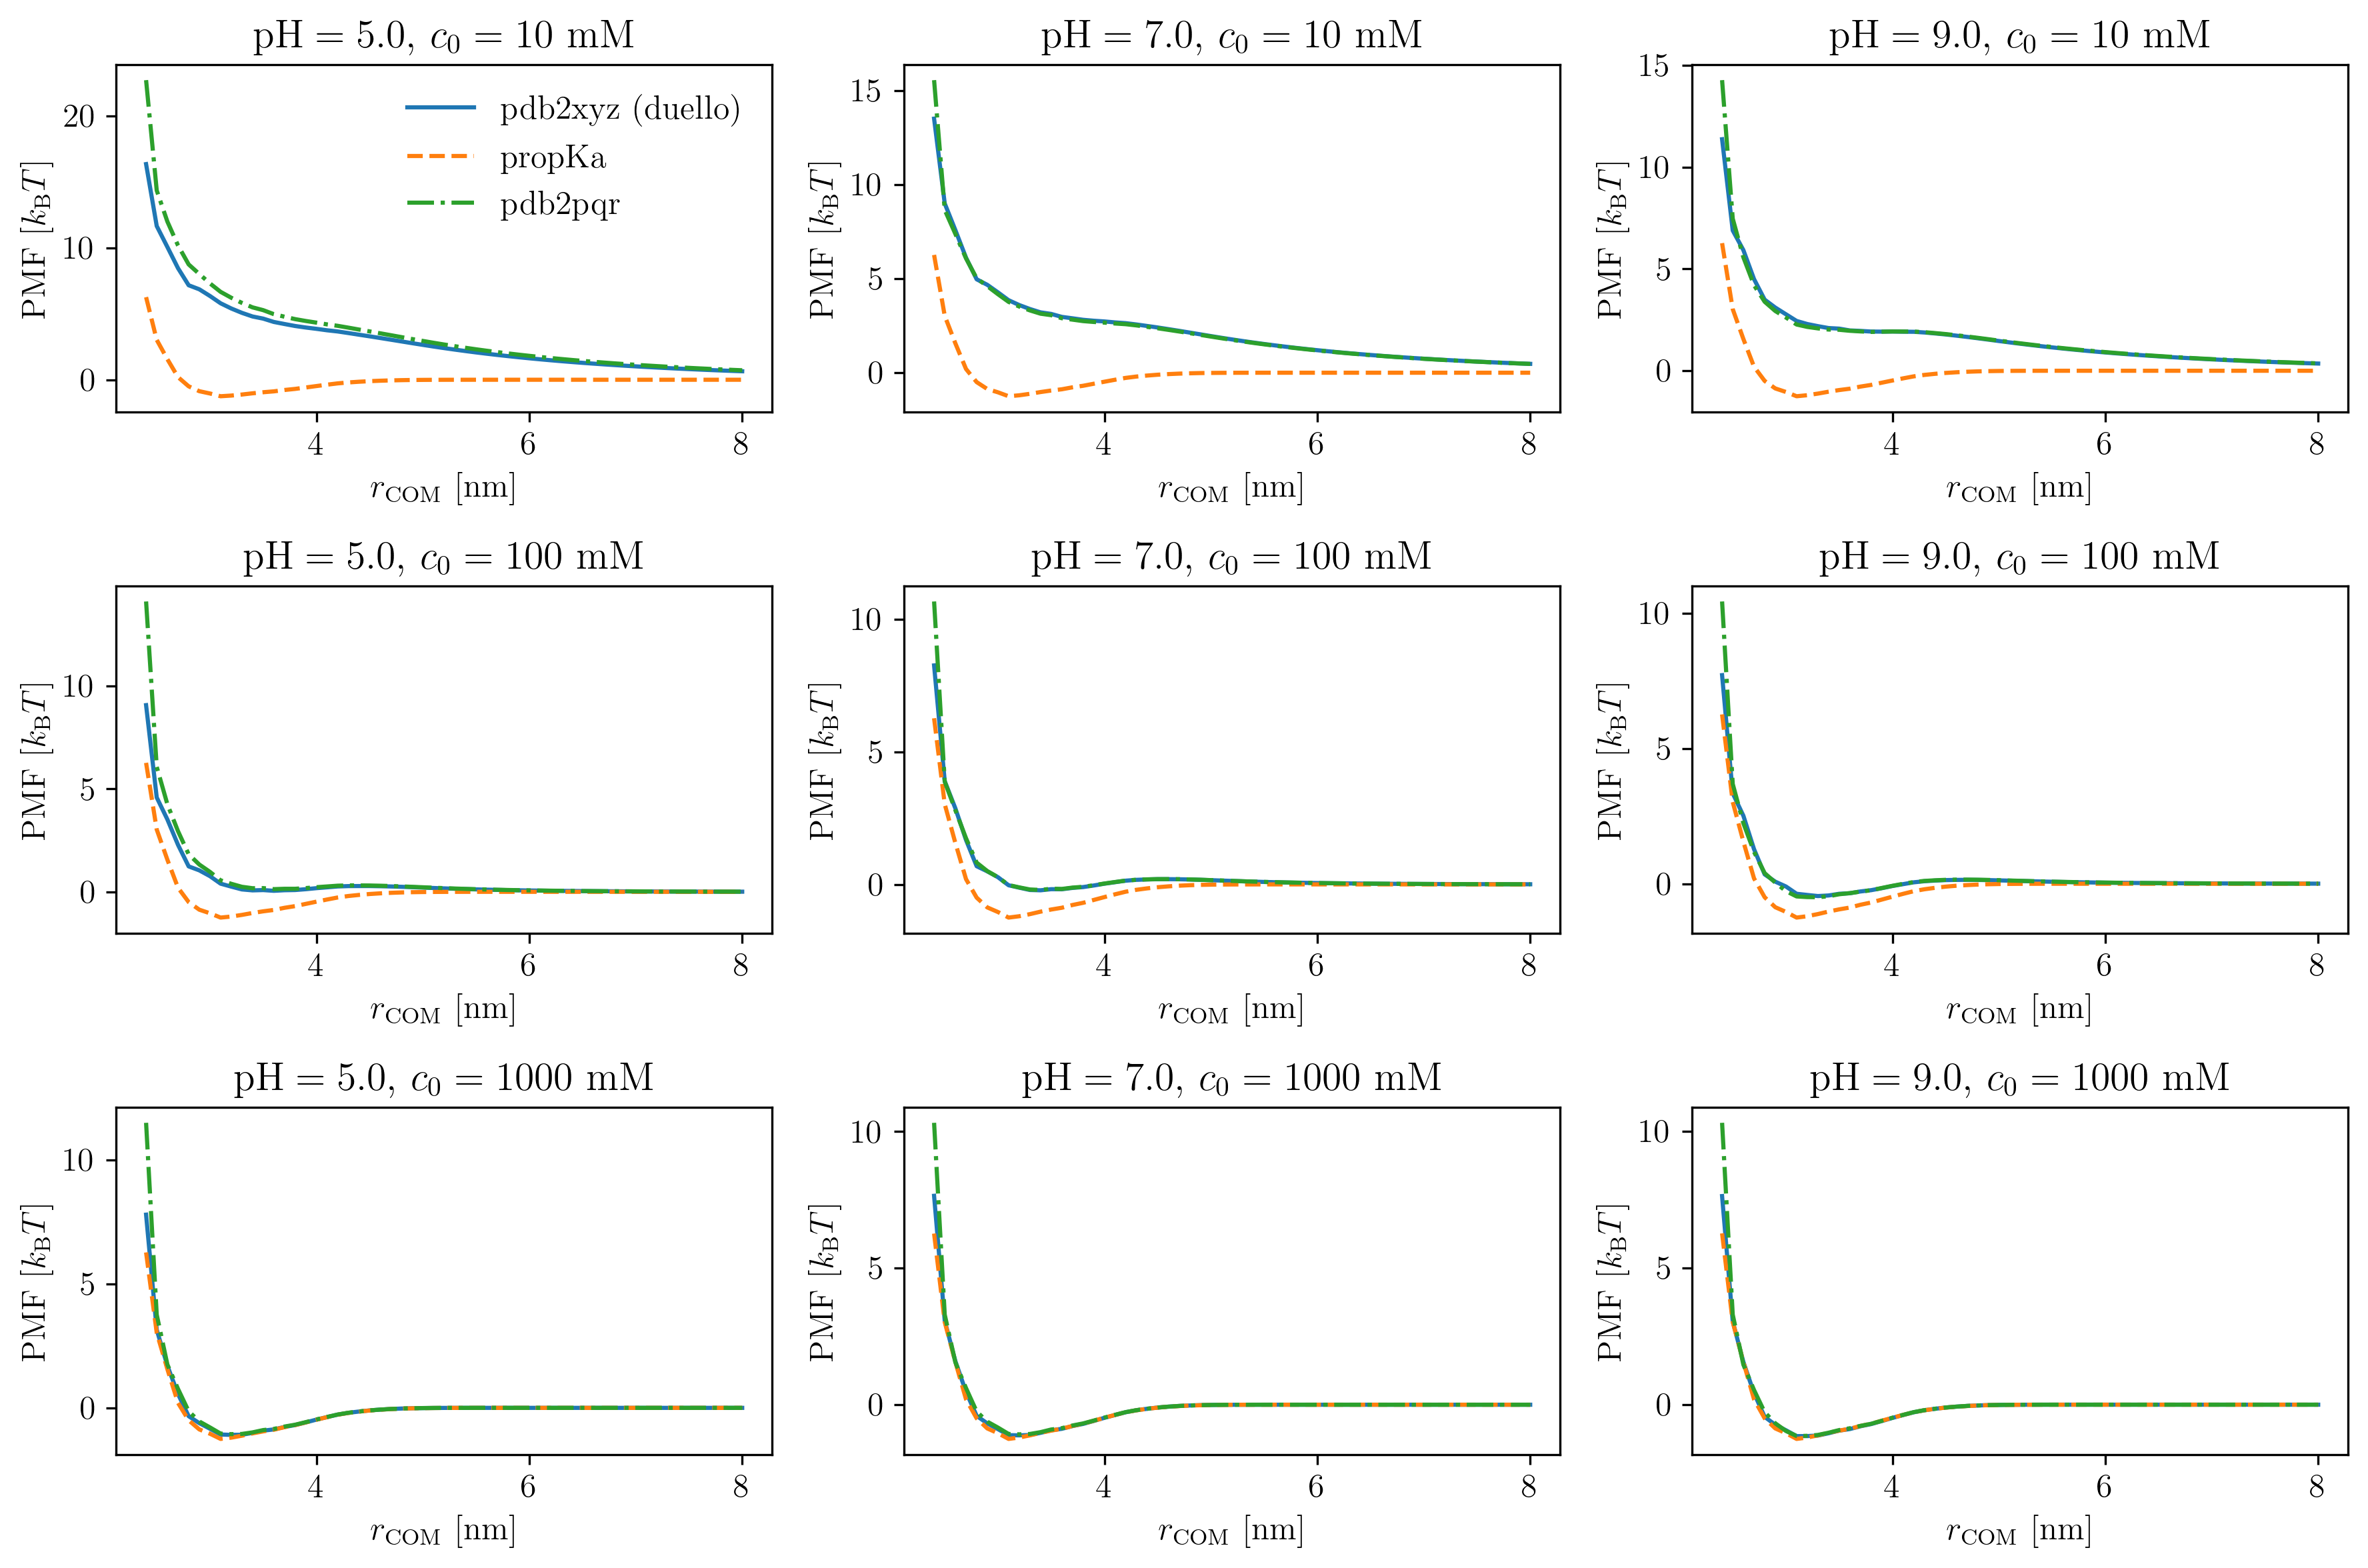

In [28]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(12,8))

for ax in figure.axes[1:]: ax.sharex(ax1)

for ax in figure.axes:

    ax.set_xlabel("$r_\\mathrm{COM}$ [nm]")
    ax.set_ylabel("PMF [$k_\\mathrm{B}T$]")
    
#ax1.set_ylim([-5,30])
#ax2.set_ylim([-5,30])

ax1.plot(0.1*data_pH5_c10[0,:,0],data_pH5_c10[0,:,1],label='pdb2xyz (duello)',ls='-')
ax1.plot(0.1*data_pH5_c10[1,:,0],data_pH5_c10[1,:,1],label='propKa',ls='--')
ax1.plot(0.1*data_pH5_c10[2,:,0],data_pH5_c10[2,:,1],label='pdb2pqr',ls='-.')
ax1.legend(frameon=False)

ax4.plot(0.1*data_pH5_c100[0,:,0],data_pH5_c100[0,:,1],label='pdb2xyz (duello)',ls='-')
ax4.plot(0.1*data_pH5_c100[1,:,0],data_pH5_c100[1,:,1],label='propKa',ls='--')
ax4.plot(0.1*data_pH5_c100[2,:,0],data_pH5_c100[2,:,1],label='pdb2pqr',ls='-.')

ax7.plot(0.1*data_pH5_c1000[0,:,0],data_pH5_c1000[0,:,1],label='pdb2xyz (duello)',ls='-')
ax7.plot(0.1*data_pH5_c1000[1,:,0],data_pH5_c1000[1,:,1],label='propKa',ls='--')
ax7.plot(0.1*data_pH5_c1000[2,:,0],data_pH5_c1000[2,:,1],label='pdb2pqr',ls='-.')

ax2.plot(0.1*data_pH7_c10[0,:,0],data_pH7_c10[0,:,1],label='pdb2xyz (duello)',ls='-')
ax2.plot(0.1*data_pH7_c10[1,:,0],data_pH7_c10[1,:,1],label='propKa',ls='--')
ax2.plot(0.1*data_pH7_c10[2,:,0],data_pH7_c10[2,:,1],label='pdb2pqr',ls='-.')

ax5.plot(0.1*data_pH7_c100[0,:,0],data_pH7_c100[0,:,1],label='pdb2xyz (duello)',ls='-')
ax5.plot(0.1*data_pH7_c100[1,:,0],data_pH7_c100[1,:,1],label='propKa',ls='--')
ax5.plot(0.1*data_pH7_c100[2,:,0],data_pH7_c100[2,:,1],label='pdb2pqr',ls='-.')

ax8.plot(0.1*data_pH7_c1000[0,:,0],data_pH7_c1000[0,:,1],label='pdb2xyz (duello)',ls='-')
ax8.plot(0.1*data_pH7_c1000[1,:,0],data_pH7_c1000[1,:,1],label='propKa',ls='--')
ax8.plot(0.1*data_pH7_c1000[2,:,0],data_pH7_c1000[2,:,1],label='pdb2pqr',ls='-.')

ax3.plot(0.1*data_pH9_c10[0,:,0],data_pH9_c10[0,:,1],label='pdb2xyz (duello)',ls='-')
ax3.plot(0.1*data_pH9_c10[1,:,0],data_pH9_c10[1,:,1],label='propKa',ls='--')
ax3.plot(0.1*data_pH9_c10[2,:,0],data_pH9_c10[2,:,1],label='pdb2pqr',ls='-.')

ax6.plot(0.1*data_pH9_c100[0,:,0],data_pH9_c100[0,:,1],label='pdb2xyz (duello)',ls='-')
ax6.plot(0.1*data_pH9_c100[1,:,0],data_pH9_c100[1,:,1],label='propKa',ls='--')
ax6.plot(0.1*data_pH9_c100[2,:,0],data_pH9_c100[2,:,1],label='pdb2pqr',ls='-.')

ax9.plot(0.1*data_pH9_c1000[0,:,0],data_pH9_c1000[0,:,1],label='pdb2xyz (duello)',ls='-')
ax9.plot(0.1*data_pH9_c1000[1,:,0],data_pH9_c1000[1,:,1],label='propKa',ls='--')
ax9.plot(0.1*data_pH9_c1000[2,:,0],data_pH9_c1000[2,:,1],label='pdb2pqr',ls='-.')

ax1.set_title("$\\mathrm{pH}=5.0$, $c_0=10$ mM")
ax4.set_title("$\\mathrm{pH}=5.0$, $c_0=100$ mM")
ax7.set_title("$\\mathrm{pH}=5.0$, $c_0=1000$ mM")
ax2.set_title("$\\mathrm{pH}=7.0$, $c_0=10$ mM")
ax5.set_title("$\\mathrm{pH}=7.0$, $c_0=100$ mM")
ax8.set_title("$\\mathrm{pH}=7.0$, $c_0=1000$ mM")
ax3.set_title("$\\mathrm{pH}=9.0$, $c_0=10$ mM")
ax6.set_title("$\\mathrm{pH}=9.0$, $c_0=100$ mM")
ax9.set_title("$\\mathrm{pH}=9.0$, $c_0=1000$ mM")

figure.tight_layout()

plt.savefig('lysozyme_methods_comparison.png', format='png', bbox_inches='tight', dpi=300)
plt.savefig('lysozyme_methods_comparison.pdf', format='pdf', bbox_inches='tight', dpi=300)

## OLD

In [107]:
def calvados_template():
    return """
{%- set f = 1.0 - sidechains -%}
{%- set zCTR = - 10**(pH-3.16) / (1 + 10**(pH-3.16)) -%}
{%- set zASP = - 10**(pH-3.43) / (1 + 10**(pH-3.43)) -%}
{%- set zGLU = - 10**(pH-4.14) / (1 + 10**(pH-4.14)) -%}
{%- set zCYS = 10**(pH-6.25) / (1 + 10**(pH-6.25)) -%}
{%- set zHIS = 1 - 10**(pH-6.45) / (1 + 10**(pH-6.45)) -%}
{%- set zNTR = 1 - 10**(pH-7.64) / (1 + 10**(pH-7.64)) -%}
{%- set zLYS = 1 - 10**(pH-10.68) / (1 + 10**(pH-10.68)) -%}
{%- set zARG = 1 - 10**(pH-12.5) / (1 + 10**(pH-12.5)) -%}
comment: "Calvados 3 coarse grained amino acid model for use with Duello / Faunus"
pH: {{ pH }}
sidechains: {{ sidechains }}
version: 0.1.0
atoms:
  - {charge: {{ "%.2f" % zCTR }}, hydrophobicity: !Lambda 0, mass: 0, name: CTR, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zNTR }}, hydrophobicity: !Lambda 0, mass: 0, name: NTR, σ: 2.0, ε: 0.8368}
{%- if sidechains %}
  - {charge: {{ "%.2f" % zGLU }}, hydrophobicity: !Lambda 0, mass: 0, name: Esc, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zASP }}, hydrophobicity: !Lambda 0, mass: 0, name: Dsc, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zHIS }}, hydrophobicity: !Lambda 0, mass: 0, name: Hsc, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zARG }}, hydrophobicity: !Lambda 0, mass: 0, name: Rsc, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zLYS }}, hydrophobicity: !Lambda 0, mass: 0, name: Ksc, σ: 2.0, ε: 0.8368}
  - {charge: {{ "%.2f" % zCYS }}, hydrophobicity: !Lambda 0, mass: 0, name: Csc, σ: 2.0, ε: 0.8368}
{%- endif %}
  - {charge: {{ "%.2f" % (zARG * f) }}, hydrophobicity: !Lambda 0.7407902764839954, mass: 156.19, name: ARG, σ: 6.56, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: {{ "%.2f" % (zASP * f) }}, hydrophobicity: !Lambda 0.092587557536158,  mass: 115.09, name: ASP, σ: 5.58, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: {{ "%.2f" % (zGLU * f) }}, hydrophobicity: !Lambda 0.000249590539426,  mass: 129.11, name: GLU, σ: 5.92, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: {{ "%.2f" % (zLYS * f) }}, hydrophobicity: !Lambda 0.1380602542039267, mass: 128.17, name: LYS, σ: 6.36, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: {{ "%.2f" % (zHIS * f) }}, hydrophobicity: !Lambda 0.4087176216525476, mass: 137.14, name: HIS, σ: 6.08, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3706962163690402, mass: 114.1,  name: ASN, σ: 5.68, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3143449791669133, mass: 128.13, name: GLN, σ: 6.02, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.4473142572693176, mass: 87.08,  name: SER, σ: 5.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.7538308115197386, mass: 57.05,  name: GLY, σ: 4.5,  ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2672387936544146, mass: 101.11, name: THR, σ: 5.62, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3377244362031627, mass: 71.07,  name: ALA, σ: 5.04, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5170874160398543, mass: 131.2,  name: MET, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.950628687301107,  mass: 163.18, name: TYR, σ: 6.46, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.2936174211771383, mass: 99.13,  name: VAL, σ: 5.86, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 1.033450123574512,  mass: 186.22, name: TRP, σ: 6.78, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5548615312993875, mass: 113.16, name: LEU, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5130398874425708, mass: 113.16, name: ILE, σ: 6.18, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.3469777523519372, mass: 97.12,  name: PRO, σ: 5.56, ε: 0.8368}
  - {charge: 0.0, hydrophobicity: !Lambda 0.8906449355499866, mass: 147.18, name: PHE, σ: 6.36, ε: 0.8368}
  - {charge: {{ "%.2f" % (zCYS * f) }}, hydrophobicity: !Lambda 0.5922529084601322, mass: 103.14, name: CYS, σ: 5.48, ε: 0.8368, custom: {alpha: {{ f * alpha }}}}
  - {charge: 0.0, hydrophobicity: !Lambda 0.5922529084601322, mass: 103.14, name: CSS, σ: 5.48, ε: 0.8368}

system:
  energy:
    nonbonded:
      # Note that a Coulomb term is automatically added, so don't specify one here!
      default:
        - !AshbaughHatch {mixing: arithmetic, cutoff: 20.0}
"""